In [1]:
import limbo
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
import os
import time
from scipy.ndimage import maximum_filter1d

%matplotlib inline

In [2]:
filename = os.environ['LIMBO_PROCFILE']
INJECT_FRB = os.environ.get('LIMBO_INJECT_FRB', False)
NSIG = os.environ.get('LIMBO_NSIG', 7)
MAX_DM = os.environ.get('LIMBO_MAX_DM', 500)
EXCLUDE_S = os.environ.get('LIMBO_EXCLUDE_S', 0.05)
REMOVE_DIR = os.environ.get('LIMBO_REMOVE_DIR', None)
SAVE_DIR = os.environ.get('LIMBO_SAVE_DIR', None)

print('Processing:', filename)
print('INJECT_FRB:', INJECT_FRB)
print('NSIG:', NSIG)
print('MAX_DM:', MAX_DM)
print('EXCLUDE_S:', EXCLUDE_S)
print('REMOVE_DIR:', REMOVE_DIR)
print('SAVE_DIR:', SAVE_DIR)

Processing: ../../data/Spectra_20230127231305.dat
INJECT_FRB: False
NSIG: 7
MAX_DM: 500
EXCLUDE_S: 0.05
REMOVE_DIR: None
SAVE_DIR: None


In [3]:
hdr = limbo.io.read_header(filename)
print('Observed:', time.ctime(hdr['Time']))
for k, v in hdr.items():
    print(f'    {k:15s}: {v}')
assert hdr['nspec'] == 4096
ker = int(np.around(EXCLUDE_S / hdr['inttime']))
print(f'ker={ker}')

Observed: Fri Jan 27 13:31:42 2023
    fpg            : limbo_500_2022-12-03_1749.fpg
    Time           : 1674855102.729957
    AccLen         : 127
    AdcCoarseGain  : 4
    FFTShift       : 2047
    Scaling        : 0
    SpecCoeff      : 4
    AdcDelay0      : 5
    AdcDelay1      : 5
    AdcDelay2      : 5
    AdcDelay3      : 5
    AdcDelay4      : 5
    AdcDelay5      : 5
    AdcDelay6      : 5
    AdcDelay7      : 5
    filename       : ../../data/Spectra_20230127231305.dat
    sample_clock   : 500000000.0
    freqs          : [1.35000000e+09 1.35012207e+09 1.35024414e+09 ... 1.59963379e+09
 1.59975586e+09 1.59987793e+09]
    inttime        : 0.001040384
    nspec          : 4096
ker=48


In [4]:
class Summary:
    
    def __init__(self):
        self.clear()
    
    def clear(self):
        self.dms = {
            (0  ,100): [],
            (100,200): [],
            (200,300): [],
            (300,400): [],
            (400,500): [],
            (500,1000): [],
            (1000,2000): [],
            (2000,3000): [],
            (3000,4000): [],
        }
        self.avg_spec = []
        self.gain_vs_t = []
    
    def add_summary(self, summary):
        dm_vs_t = summary['dmt']
        dms = summary['dms']
        for (lo, hi) in self.dms.keys():
            try:
                self.dms[lo, hi].append(np.max(dm_vs_t[:,np.logical_and(hi > dms, dms >= lo)], axis=1))
            except(ValueError):
                pass
    
    def get_summary(self):
        rv = {}
        for k, v in self.dms.items():
            try:
                rv[k] = np.concatenate(v)
            except(ValueError):
                pass
        return rv
    
    def get_events(self, ker, nsig, summary=None, in_keys=[(300,400),(400,500)], out_keys=[(0,100),(100,200)],
                   verbose=True):
        if summary is None:
            summary = self.get_summary()
            
        events = {}
        for k, v in summary.items():
            if type(k) == str:
                continue
            avg = np.median(v)
            sig = np.median(np.abs(v - avg))
            zscore = (v - avg) / sig
            if verbose:
                print(f'DM={k}: avg={avg:7.2f} +/- {sig:7.2f}')
            events[k] = zscore
            
        events['out'] = np.array([events[k] for k in out_keys]).max(axis=0)
        events['in'] = np.array([events[k] for k in in_keys]).max(axis=0)
        events['thresh'] = maximum_filter1d(events['out'], size=ker, mode='nearest').clip(nsig, np.Inf)
        events['interesting'] = (events['in'] > events['thresh'])
        return events

In [5]:
# Process the data

hdr, data = limbo.io.read_file(filename, nspec=-1)
dts = hdr['times'] - hdr['times'][0]

if INJECT_FRB:
    sim_frb = limbo.sim.make_frb(hdr['times'], hdr['freqs'], DM=331,
                                 pulse_width=0.12e-3, pulse_amp=25, t0=hdr['times'][500])
    sim_frb *= (limbo.processing.FMDL / limbo.processing.FMDL.max())
    data = data + sim_frb
    
dmt = limbo.processing.process_data(hdr, data, maxdm=MAX_DM)

summary = Summary()
summary.add_summary(dmt)
report = summary.get_summary()
events = summary.get_events(ker, NSIG, summary=report)
save_file = np.any(events['interesting'])

DM=(0, 100): avg=1357.82 +/-  214.01
DM=(100, 200): avg=1382.09 +/-  227.05
DM=(200, 300): avg=1352.03 +/-  201.20
DM=(300, 400): avg=1359.18 +/-  207.97
DM=(400, 500): avg=1354.30 +/-  205.89


In [6]:
print(f"DMs: {dmt['dms'][0]} -- {dmt['dms'][-1]}")
for k, v in events.items():
    if k == 'interesting':
        print(f'{k}: {(v > 0).sum()} event(s)')
    elif k != 'thresh':
        print(f'{k}: {(v > NSIG).sum()} event(s)')
print('\nSave file:', save_file)

DMs: 0.0 -- 499.51171875
(0, 100): 86 event(s)
(100, 200): 6 event(s)
(200, 300): 3 event(s)
(300, 400): 1 event(s)
(400, 500): 3 event(s)
out: 89 event(s)
in: 4 event(s)
interesting: 1 event(s)

Save file: True


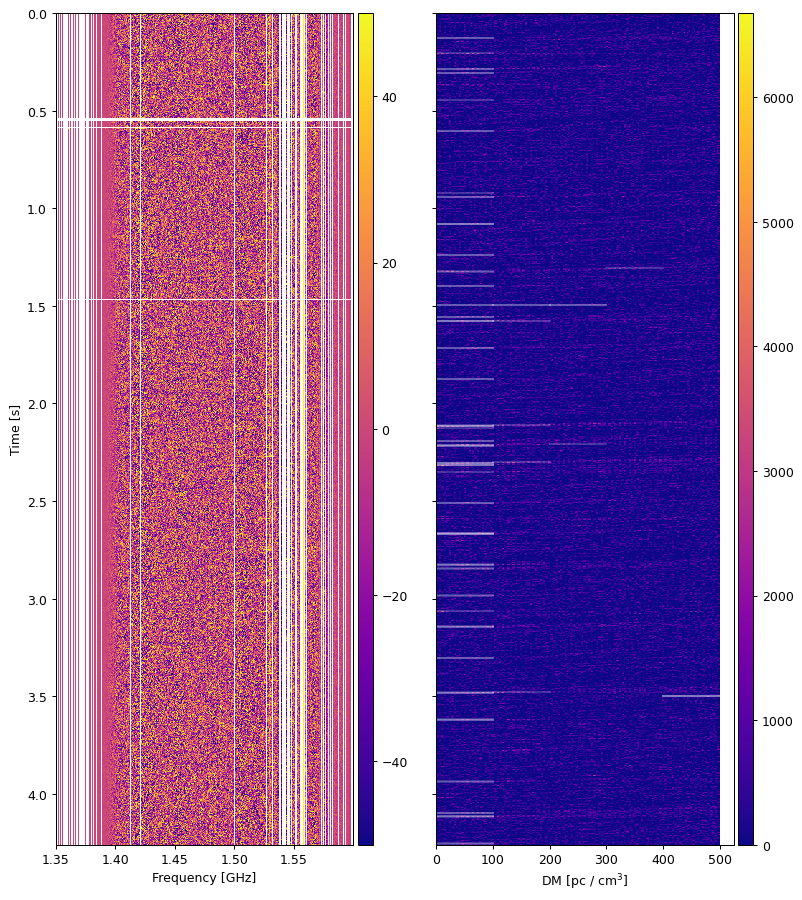

In [7]:
fig, axes = plt.subplots(ncols=2, sharey=True, figsize=(10, 12), dpi=90)

scale = 50
im0 = axes[0].imshow(np.where(dmt['diff'] == 0, np.nan, dmt['diff']),
               extent=(hdr['freqs'][0] / 1e9, hdr['freqs'][-1] / 1e9, dts[-1], dts[0]),
               cmap='plasma', vmax=scale, vmin=-scale, interpolation='nearest', aspect='auto')
im1 = axes[1].imshow(dmt['dmt'], cmap='plasma', vmin=0,
               extent=(dmt['dms'][0], dmt['dms'][-1], dts[-1], dts[0]),
               interpolation='nearest', aspect='auto')
for k, v in events.items():
    if type(k) is str:
        continue
    for t in dts[v > NSIG]:
        axes[1].plot(k, (t, t), 'w', alpha=0.2)
axes[0].set_xlabel('Frequency [GHz]')
axes[1].set_xlabel('DM [pc / cm$^3$]')
axes[0].set_ylabel('Time [s]')
cax = make_axes_locatable(axes[0]).append_axes('right', size='5%', pad=0.05)
_ = plt.colorbar(im0, cax=cax)
cax = make_axes_locatable(axes[1]).append_axes('right', size='5%', pad=0.05)
_ = plt.colorbar(im1, cax=cax)

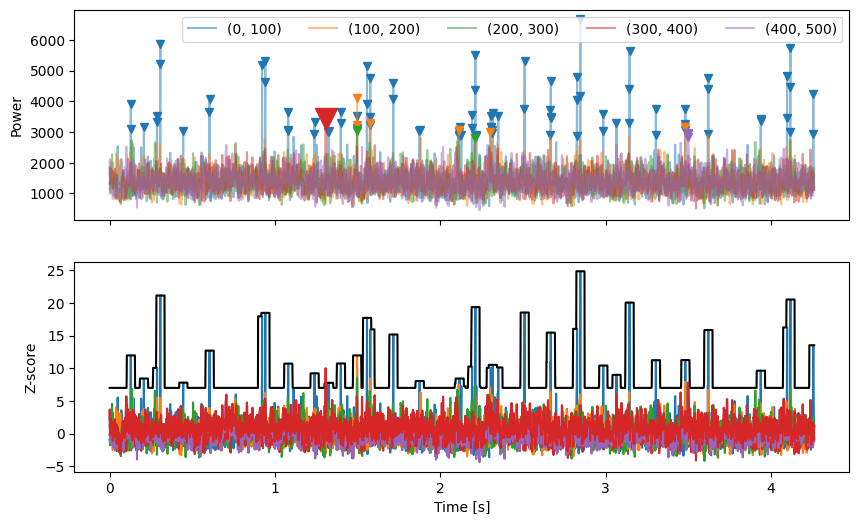

In [8]:
fig, axes = plt.subplots(nrows=2, sharex=True, figsize=(10, 6))
colors = {}
for k, v in events.items():
    if type(k) == str:
        continue
    line, = axes[0].plot(dts, report[k], label=k, alpha=0.5)
    colors[k] = line.get_color()
    axes[0].plot(dts[v > NSIG], report[k][v > NSIG], 'v', color=line.get_color())
    axes[1].plot(dts, v, color=colors[k])
    
k = (300, 400)
axes[0].plot(dts[events['interesting']], report[k][events['interesting']], 'v', color=colors[k], markersize=16)
#axes[1].plot(dts, maximum_filter1d(events['out'], size=ker, mode='nearest'))
axes[1].plot(dts, events['thresh'], 'k')
axes[1].plot(dts, events['in'], color=colors[k])
axes[1].set_xlabel('Time [s]')
axes[0].set_ylabel('Power')
axes[1].set_ylabel('Z-score')
_ = axes[0].legend(ncol=5)

In [9]:
print('Save file:', save_file)

if save_file:
    if SAVE_DIR != None:
        outfile = os.path.join(SAVE_DIR, os.path.basename(filename))
        print(f'Moving {filename} -> {outfile}')
        os.rename(filename, outfile)
else:
    if REMOVE_DIR != None:
        outfile = os.path.join(REMOVE_DIR, os.path.basename(filename))
        print(f'Moving {filename} -> {outfile}')
        os.rename(filename, outfile)

Save file: True


In [10]:
#%matplotlib notebook